In [7]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.rec.reconstruction as rec
import algotom
import algotom.prep.calculation as calc
import h5py as h5f
import timeit
import multiprocessing as mp
from joblib import Parallel, delayed
from skimage.measure import profile_line
import ast

# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


# Workflow starts here!

In [8]:
###################### need to change start
ipts="29298"
###################### need to change end

In [9]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
output_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
os.listdir(output_loc)

['2022_09_29_sample2.h5',
 '2022_09_29_sample1.h5',
 '2022_12_02_tube1.h5',
 '2022_12_04_tube4.h5',
 '2022_12_03_tube2_redone.h5',
 '2022_09_29_sample4.h5',
 '2022_09_29_sample3.h5',
 '2022_12_04_tube3.h5']

In [10]:
###################### need to change start
sample_name = "2022_09_29_sample1"
hdf5 = output_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [11]:
losa.get_hdf_tree(hdf5)
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
history_dict

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (783,)
    │   ├── ang_rad (783,)
    │   ├── fname (783,)
    │   ├── proj000_idx (1,)
    │   └── proj180_idx (1,)
    ├── proj
    │   │
    │   ├── dc_fake (1850, 750)
    │   ├── ob_fake (1850, 750)
    │   ├── proj_mlog_to_recon (783, 1850, 750)
    │   └── proj_norm (783, 1850, 750)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 2048)
    │   ├── fluc_corr_roi_min (850, 95)
    │   ├── ob_min (2048, 2048)
    │   ├── proj_crop_roi_min (1850, 750)
    │   └── proj_min (2048, 2048)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── pixel_size_um (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (1850, 750, 750)
    └── sino
        │
        ├── sino_mlog_to_recon (1850, 783, 750)
        └── sino_norm (1850, 783, 750)


{'crop': True,
 'gamma_filter': True,
 'normalization': True,
 'beam_fluc_corr': True,
 'tilt_corr': 0.17029058196695485,
 'rot_center': 372.6065979003906,
 'minus_log': True,
 'ring_removal': 'bm3d',
 'beam_fluc_corr_roi': {'left': 5, 'right': 100, 'top': 250, 'bottom': 1100},
 'crop_roi': {'left': 750, 'right': 1500, 'top': 100, 'bottom': 1950}}

In [18]:
proj_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
proj_norm = losa.load_hdf(hdf5, key_path='tomo/proj/proj_norm')

In [12]:
recon = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')

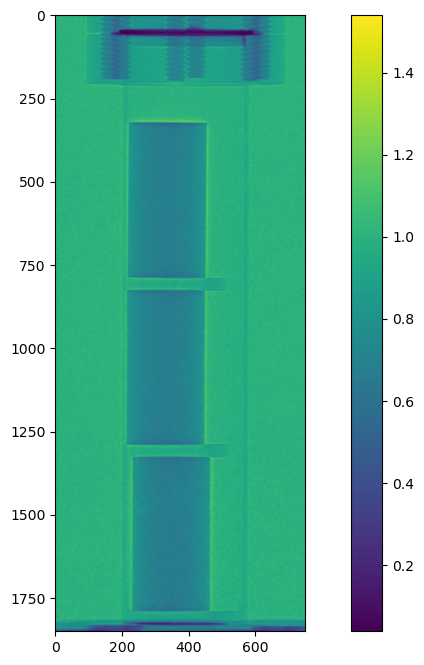

In [19]:
plt.imshow(proj_norm[400])
plt.colorbar()
plt.show()

# Export recon files

In [8]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

# Export proj files

In [9]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon/" + sample_name + "_norm"
dxchange.write_tiff_stack(proj_norm, fname=save_to + "/raw", overwrite=True, digit=4)
# dxchange.write_tiff(ob_output, fname=save_to + '/ob_0000', overwrite=True)
# dxchange.write_tiff(dc_output, fname=save_to + '/dc_0000', overwrite=True)